In [2]:
# Display all the models we have trained

import os
import json
import pandas as pd

DIR_PATH='/mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/'

make_key = lambda x: f"ntop={x['num_topics']},nstyl={x['num_styles']},kap={x['kappa_prior_scale']},thet={x['theta_prior_scale']},"

best_experiments = {}

for dir in os.listdir(DIR_PATH):
    if not dir.startswith('2023'):
        continue
    try:
        checkpoint = [x for x in os.listdir(os.path.join(DIR_PATH,dir)) if x.endswith('.pt')][0] #os.path.join(DIR_PATH, dir, 'info.json')

        info = json.load(open(os.path.join(DIR_PATH, dir, 'info.json')))
        best_loss = pd.read_csv(os.path.join(DIR_PATH, dir, 'elbos.json'))['val_elbo'].min()
        exp_name = make_key(info)
        path_to_model = os.path.join(DIR_PATH, dir, checkpoint)

        if exp_name not in best_experiments or best_experiments[exp_name]['loss'] > best_loss:
            best_experiments[exp_name] = {'loss': best_loss, 'path': path_to_model}

        assert info['MAX_DF'] == 0.7

        
    except PermissionError:
        continue



best_experiments = list(best_experiments.items())
best_experiments.sort(key=lambda x: x[1]['loss'])
for x in best_experiments:
    print(x)

('ntop=10,nstyl=10,kap=1.0,thet=1.0,', {'loss': 4784.723134994507, 'path': '/mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_11_57_05/model_epoch19_4806.112176895142.pt'})
('ntop=20,nstyl=20,kap=1.0,thet=1.0,', {'loss': 4808.00599861145, 'path': '/mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_12_23_57/model_epoch19_4993.699951171875.pt'})
('ntop=5,nstyl=5,kap=1.0,thet=1.0,', {'loss': 4844.649747848511, 'path': '/mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_11_36_17/model_epoch17_4883.565605163574.pt'})
('ntop=5,nstyl=5,kap=3.0,thet=1.0,', {'loss': 4853.584001541138, 'path': '/mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_02_51_27/model_epoch13_4921.163795471191.pt'

In [3]:
# Load the processed features

import pyro
import torch
import pickle 

from prod_slda.model import ProdSLDA

from sklearn.feature_extraction.text import CountVectorizer



MODEL_PATH = '/mnt/swordfish-pool2/ndeas/prob_models/final_results/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-21_11_57_05/model_epoch19_4806.112176895142.pt'
DATA_DIR_PATH = '/mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/maxdf0.7_mindf20_DATA'

with open(os.path.join(DATA_DIR_PATH, 'bows.pickle'), 'rb') as in_file:
    bows = pickle.load(in_file)
        
with open(os.path.join(DATA_DIR_PATH, 'meta_vectorized.pickle'), 'rb') as in_file:
    meta_vectorized = pickle.load(in_file)    

with open(os.path.join(DATA_DIR_PATH, "raw_text.json"), 'r') as in_file:
    raw_text = json.load(in_file)    

with open(os.path.join(DATA_DIR_PATH, "authors_json.json"), 'r') as in_file:
    authors_json = json.load(in_file)    

with open(os.path.join(DATA_DIR_PATH, "meta_feature_to_names.json"), 'r') as in_file:
    meta_feature_to_names = json.load(in_file)

with open(os.path.join(DATA_DIR_PATH, "vectorizer.pickle"), 'rb') as in_file:
    vectorizer = pickle.load(in_file)

/home/horvitz/miniconda3/envs/style_lda/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.1.3 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# Load the best model
pyro.clear_param_store()

prodsdla = torch.load(MODEL_PATH, map_location=torch.device('cuda:0'))
prodsdla.eval()


ProdSLDA(
  (encoder): GeneralEncoder(
    (drop): Dropout(p=0, inplace=False)
    (fc1s): ModuleDict(
      (doc): Linear(in_features=3098, out_features=128, bias=True)
    )
    (fc2): Linear(in_features=128, out_features=96, bias=True)
    (fcmu): Linear(in_features=96, out_features=10, bias=True)
    (fclv): Linear(in_features=96, out_features=10, bias=True)
    (bnmu): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (bnlv): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (style_encoder): GeneralEncoder(
    (drop): Dropout(p=0, inplace=False)
    (fc1s): ModuleDict(
      (casing): Linear(in_features=3, out_features=64, bias=True)
      (doc): Linear(in_features=3098, out_features=128, bias=True)
      (emoji_task): Linear(in_features=20, out_features=64, bias=True)
      (formality): Linear(in_features=2, out_features=64, bias=True)
      (pos_bigrams): Linear(in_features=324, out_features=64, bias=True)


In [1]:
# Print out the top beta terms for each topic and style


from tqdm import tqdm
def top_beta_document(model, vectorizer, top_k=20):
    betas_document = model.beta_document()
    features_to_betas = {}
    idx_to_name = {v:k for k,v in vectorizer.vocabulary_.items()}
    for feature, logits in betas_document.items():
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, top_k, dim=-1)
        
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
                
    return features_to_betas

def top_beta_meta(model, meta_feature_to_names, top_k=20):
    betas_metas = model.beta_meta()
    features_to_betas = {}
    for feature, logits in betas_metas.items():
        idx_to_name = {i:k for i,k in enumerate(meta_feature_to_names[feature])}
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, min(top_k,logits.shape[-1]), dim=-1)
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
        
    return features_to_betas 


In [6]:
top_words_per_latent = top_beta_document(prodsdla, vectorizer,  top_k=20)
top_meta_per_latent = top_beta_meta(prodsdla, meta_feature_to_names, top_k=20)

print('Document Term Info')
for latent, top in top_words_per_latent.items():
    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

print('Meta Var Info')
for latent, top in top_meta_per_latent.items():
    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()



100%|██████████| 10/10 [00:00<00:00, 112447.83it/s]

Document Term Info
	beta_topic (10):
		 beta_topic (0):
['deals', 'entered', 'price', 'did', 'sorry', 'correct', '503', 'deal', '464', 'sitara', 'volume', 'bob', 'ticket', 'said', 'missing', 'chris', 'check', 'fee', 'didn', 'sold']

		 beta_topic (1):
['pm', '04', '2000', 'task', '03', '05', '06', '08', '09', '01', 'assignment', '12', '2001', '07', '13', '02', 'dated', 'copies', 'sale', 'received']

		 beta_topic (2):
['works', 'x3', 'highlighted', 'rgds', 'df', 'tana', 'year', 'counterparty', 'gillaspie', 'llc', 'eric', 'blue', 'products', 'authorized', '8331', 'trading', 'pls', 'does', 'building', 'power']

		 beta_topic (3):
['tomorrow', 'going', '000', 'want', 'explorer', 'friday', '30', 'night', 'tap', 'free', 'sure', 'll', 'talk', 'just', 'make', 'meeting', 'wanted', 'ls', 'try', 'teco']

		 beta_topic (4):
['attached', 'changes', 'questions', 'draft', 'comments', 'copy', 'xls', 'elizabeth', 'updated', 'version', 'revised', 'provide', 'file', 'letter', 'latest', 'forward', '6349'

In [7]:
# cleaner way of organizing features by style

print('Meta Var Info')
number = 10
for i in range(10):
    for latent, top in top_meta_per_latent.items():

        # print(f'\t{latent} ({len(top)}):')
        # for i, results in enumerate(top):
            print(f'\t\t {latent} ({i}):\n{top[i]["top"]}')
            print()
            print()
            
    print("------\n"*3)


Meta Var Info
		 casing (0):
['mixed', 'upper', 'lower']


		 emoji_task (0):
['❤', '💙', '😊', '🎄', '🇺🇸', '😘', '😉', '💜', '💕', '💯', '📸', '😁', '😜', '🔥', '☀', '😂', '😍', '📷', '✨', '😎']


		 formality (0):
['Formal', 'Informal']


		 pos_bigrams (0):
['pos_bigrams:ADV AUX', 'pos_bigrams:ADJ ADP', 'pos_bigrams:ADV ADJ', 'pos_bigrams:ADJ SCONJ', 'pos_bigrams:PUNCT AUX', 'pos_bigrams:ADJ PUNCT', 'pos_bigrams:ADV ADP', 'pos_bigrams:INTJ PART', 'pos_bigrams:INTJ VERB', 'pos_bigrams:SCONJ SCONJ', 'pos_bigrams:PUNCT INTJ', 'pos_bigrams:SPACE ADV', 'pos_bigrams:SCONJ SPACE', 'pos_bigrams:INTJ NUM', 'pos_bigrams:NUM PART', 'pos_bigrams:VERB VERB', 'pos_bigrams:ADJ SPACE', 'pos_bigrams:PRON INTJ', 'pos_bigrams:AUX ADV', 'pos_bigrams:SCONJ ADP']


		 punc_tags (0):
['punctuation:*', 'punctuation:&', 'punctuation:?', 'punctuation:%', 'punctuation:!', 'punctuation:;', 'punctuation:`', 'punctuation:–', 'punctuation:"', 'punctuation:’', 'punctuation:(', 'punctuation:‘', "punctuation:'", 'punctuation:,', 'p

In [9]:
bows['training'].shape

(66668, 3098)

In [10]:
meta_vectorized['training'] = {k:v.toarray() for k,v in meta_vectorized['training'].items()}
bows['training'] = bows['training'].toarray()

In [11]:
# Generate style and topic embeddings for all the documents


import torch.nn.functional as F
DEVICE='cuda'
author_to_result = {}


with torch.no_grad():

    for i in tqdm(range(len(raw_text['training']))):
        text = raw_text['training'][i]
        author = authors_json['training'][i]
        b = torch.tensor(torch.tensor(bows['training'][i]).unsqueeze(0).float().to(DEVICE))
        m = {k:torch.tensor(v[i]).unsqueeze(0).float().to(DEVICE) for k,v in meta_vectorized['training'].items()}

        theta, kappa =  prodsdla.guide(b, m)

        theta = F.softmax(theta,-1).detach().cpu()
        kappa = F.softmax(kappa,-1).detach().cpu()
        if author not in author_to_result:
            author_to_result[author] = []
            
        author_to_result[author].append((text, theta, kappa))


  0%|          | 0/66668 [00:00<?, ?it/s]/tmp/ipykernel_3366365/1591110549.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(torch.tensor(bows['training'][i]).unsqueeze(0).float().to(DEVICE))
100%|██████████| 66668/66668 [02:41<00:00, 413.36it/s]


In [12]:
author_to_result[author]

[("Hi team,\n\nJust wanted to give you all a quick update. I've made some changes to the presentation slides we discussed earlier. I have removed a few redundant sections and reorganized the flow to make it more concise. However, please keep in mind that this is still a draft and should not be used as-is. Looking forward to any feedback you may have.\n\nThanks,\n[Author's Name]",
  tensor([[0.0266, 0.0442, 0.0538, 0.1305, 0.5361, 0.0445, 0.0501, 0.0465, 0.0377,
           0.0300]]),
  tensor([[0.0018, 0.0034, 0.0038, 0.0016, 0.0018, 0.0018, 0.9724, 0.0071, 0.0035,
           0.0029]])),
 ('Hey Sarah, \n\nI spoke with Mark and he mentioned that the meeting has been rescheduled. He said he would send out an updated calendar invite soon. Just wanted to let you know. \n\nThanks,\nTony',
  tensor([[0.0407, 0.0700, 0.0550, 0.3953, 0.1482, 0.0544, 0.0599, 0.0709, 0.0441,
           0.0617]]),
  tensor([[0.0109, 0.0078, 0.6630, 0.0111, 0.0238, 0.0172, 0.1677, 0.0760, 0.0116,
           0.0107]

In [13]:
author_list = sorted(author_to_result.keys())

In [14]:
# Get top examples for each topic and style

num_topics = len(author_to_result[author_list[0]][0][1][0])
num_styles = len(author_to_result[author_list[0]][0][2][0])

topics_to_top_examples = {i:[] for i in range(num_topics)}
style_to_top_examples = {i:[] for i in range(num_styles)}

for a in tqdm(author_to_result):
    for text, theta, kappa in author_to_result[a]:
        for i, x in enumerate(theta[0]):
            topics_to_top_examples[i].append((x, a,text))
        for i, x in enumerate(kappa[0]):
            style_to_top_examples[i].append((x, a,text))
            
            
topics_to_top_examples = {i: sorted(v) for i,v in topics_to_top_examples.items()}        
style_to_top_examples = {i: sorted(v) for i,v in style_to_top_examples.items()}  
    

100%|██████████| 980/980 [00:06<00:00, 153.85it/s]


In [15]:
for i, v in topics_to_top_examples.items():
    print("TOPIC",i)
    print('\n-'.join(list(set([str((x[1],x[2])) for x in v[-30:]]))))
    print()

for i, v in style_to_top_examples.items():
    print("STYLE",i)
    print('\n-'.join(list(set([str((x[1],x[2])) for x in v[-30:]]))))
    print()

TOPIC 0
('From: mary.poorman@enron.com', 'The meter shows flow the first two day, the deal to sell to San Jac is expired. Do you want me to extend the deal to cover the volume? Mary')
-('From: evelyn.metoyer@enron.com', 'deal 464181 Diana Scholtes Prebon shows Cob......we show Mid-C deal 464182 Dianna Scholtes Prebon shows Cob.....we show Mid-C')
-('From: evelyn.metoyer@enron.com', 'Hi Kate, Jeff Richter deal 502122 Amerex says the delivery point should be NP-15 and we have SP-15. I was out on yesterday and someone else verballed my trades for me. Thanks!!')
-('From: evelyn.metoyer@enron.com', 'BLOOMBERG Tom Alonso deal 555159 Bloomberg shows cp as AZPS ......enpower has Pinnacle West PREBON All deals are o.k. AMEREX WEST All deals are o.k.')
-('From: jane.tholt@enron.com', 'PNM is incorrect. The price is $4.86. Tell them that this deal is for west texas pool gas and that we never sell west texas pool gas based on a san juan gas daily.')
-('From: chris.dorland@enron.com', 'Kathy, Could

In [16]:
# Logic for projecting + plotting the embeddings

import numpy as np
from sklearn.decomposition import PCA
# import umap
import matplotlib.pyplot as plt

def compute_projection(x):
    pca = PCA(n_components=2)
    pca.fit(x)
    return pca.transform(x), pca

# def compute_projection(x):
#     mapper = umap.UMAP()
#     mapper.fit(x)
#     return mapper.transform(x)

def plot_projection(x, y, authors, title):
    color = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'black', 'pink', 'brown', 'gray']

    nongpt_x = []
    nongpt_y = []
    human_labels = []

    gpt_x = []
    gpt_y = []
    gpt_labels = []

    for i, a in enumerate(authors):
        if a.startswith('gpt3.5_'):
            gpt_x.append(x[i])
            gpt_y.append(y[i])
            gpt_labels.append(a)
        else:
            nongpt_x.append(x[i])
            nongpt_y.append(y[i])
            human_labels.append(a)

    plt.figure(figsize=(5,5))
    plt.scatter(nongpt_x, nongpt_y, color='red', label='Human', marker='o', s=10)
    plt.scatter(gpt_x, gpt_y, color='blue', label='ChatGPT', marker='^', s=10)

    plt.title(title)
    plt.axis('off')

    plt.legend(loc='lower right')
    plt.show()


In [17]:
# Combine all the embeddings

thetas = []
kappas = []
a_labels = []
texts = []

for a in tqdm(sorted(author_to_result.keys())):
    for text, theta, kappa in author_to_result[a]:
        kappas.append(kappa[0])
        thetas.append(theta[0])
        a_labels.append(a)
        texts.append(text)

  0%|          | 0/980 [00:00<?, ?it/s]

100%|██████████| 980/980 [00:00<00:00, 2116.74it/s]


In [18]:
# Compare intra-author vs inter-author KL divergence using sample

from scipy.special import rel_entr
import random 

ratio_theta = []
ratio_kappa = []

max = 10


human_authors = {a:v for a,v in author_to_result.items() if not a.startswith('gpt3.5_')}

for a, v in tqdm(list(human_authors.items())): 
    within_theta = []
    within_kappa = []

    first_choices = list(range(len(v)))
    second_choices = list(range(len(v)))

    random.shuffle(first_choices)
    random.shuffle(second_choices)

    for i in first_choices[:3]:
        for j in second_choices[:3]:
            if i == j:
                continue
            text1, thetai, kappai = v[i]
            text2, thetaj, kappaj = v[j]
            # if text1 == text2:
                # continue
            within_theta.append(np.sum(rel_entr(thetai.numpy(), thetaj.numpy())))
            within_kappa.append(np.sum(rel_entr(kappai.numpy(), kappaj.numpy())))

    # print(within_theta)
    without_theta = []
    without_kappa = []
    for i in range(len(v)):
        others = list(human_authors.items())
        random.shuffle(others)

        for a2, v2 in others[:5]:
            if a == a2:
                continue
            for j in range(len(v2))[:3]:
                text1, thetai, kappai = v[i]
                text2, thetaj, kappaj = v2[j]
                # if text1 == text2:
                    # continue
                without_theta.append(np.sum(rel_entr(thetai.numpy(), thetaj.numpy())))
                without_kappa.append(np.sum(rel_entr(kappai.numpy(), kappaj.numpy())))
                # break

    ratio_theta.append(np.mean(within_theta) / np.mean(without_theta))
    ratio_kappa.append(np.mean(within_kappa) / np.mean(without_kappa))


  0%|          | 0/880 [00:00<?, ?it/s]

 88%|████████▊ | 770/880 [00:56<00:04, 25.40it/s]/home/horvitz/miniconda3/envs/style_lda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/horvitz/miniconda3/envs/style_lda/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 880/880 [01:00<00:00, 14.48it/s]


In [19]:
#exclude nan
print(np.mean([r for r in ratio_theta if not np.isnan(r)]))
print(np.mean([r for r in ratio_kappa if not np.isnan(r)]))


0.6676989
0.7518585


In [20]:
# PCA for kappas

kappa_proj, pca_kappa = compute_projection(np.stack(kappas)))
a_labels_kappa = a_labels


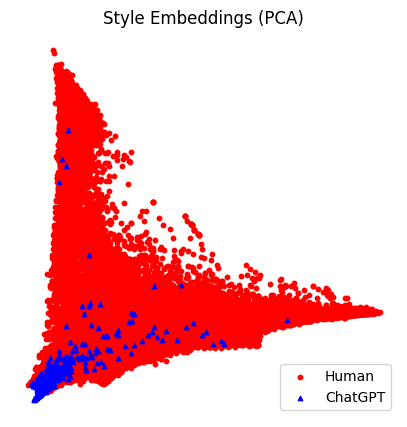

In [21]:
# Plot PCA for kappas

plot_projection(kappa_proj[:,0], kappa_proj[:,1], a_labels_kappa, 'Style Embeddings (PCA)')


In [22]:
# PCA for theta

theta_proj, pca_theta = compute_projection(np.stack(thetas))
a_labels_theta = a_labels

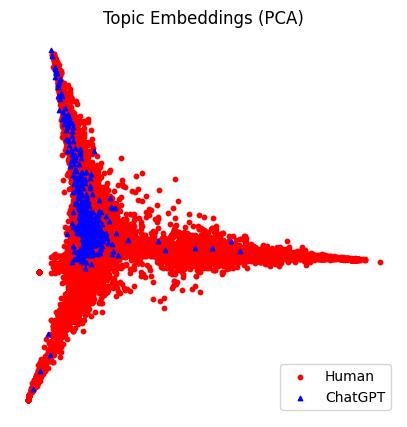

In [23]:
# Plot PCA

plot_projection(theta_proj[:,0], theta_proj[:,1], a_labels_theta, title='Topic Embeddings (PCA)')

In [24]:
import math

# Compare a sample of gpt3.5 to human centroids

def plot_projection_comparison(x, y, authors):
    color = ['pink', 'blue','red','black'] #['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'black', 'pink', 'brown', 'gray']


    
    is_gpt = [a for a in authors if a.startswith('gpt3.5_')]
    authors_paired = [a for a in authors if 'gpt3.5_'+a in is_gpt]

    plt.figure(figsize=(5,5))

    for c, chosen_a in enumerate(sorted(set(authors_paired))[:20]): #[:len(color)]):
        nongpt_x = []
        nongpt_y = []
    
        gpt_x = []
        gpt_y = []

        for i, a in enumerate(authors):
            if chosen_a not in a: continue
            if a.startswith('gpt3.5_'):
                gpt_x.append(x[i])
                gpt_y.append(y[i])
            else:
                nongpt_x.append(x[i])
                nongpt_y.append(y[i])

        

                
        
   
        plt.scatter(gpt_x, gpt_y, color='blue', label='ChatGPT Impersonator', marker='^')

        mean_x = np.mean(nongpt_x)
        mean_y = np.mean(nongpt_y)
        plt.scatter(mean_x, mean_y, color='red', marker='o', s=10, label='Human Centroid')

        for i in range(len(gpt_x)):
            plt.plot([gpt_x[i], mean_x], [gpt_y[i], mean_y], color='black', linestyle='--', linewidth=0.5) # length_includes_head=True)

    plt.axis('off')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='lower right')
    
    plt.show()


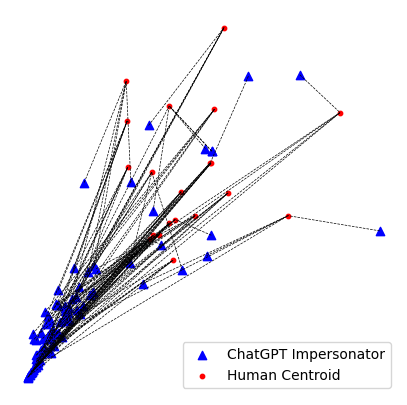

In [25]:
plot_projection_comparison(kappa_proj[:,0], kappa_proj[:,1], a_labels)

In [26]:
# plot histogram of gpt3.5 vs human for specified feature

def generate_per_feature_histogram(author_to_result, feature):
    _, theta1, kappa_1 = author_to_result[list(author_to_result.keys())[0]][0]
    print(kappa_1.shape)
    if feature == 'theta':
        num = theta1.shape[-1]
    elif feature == 'kappa':
        num = kappa_1.shape[-1]
    else:
        raise ValueError(f'Unknown feature {feature}')

    fig, ax = plt.subplots(num, 1, figsize=(8,18))

    fig.suptitle(f'Per {feature.capitalize()} Densities', fontsize=16)

    for i in range(num):
        print(i)
        gpt_feature = []
        human_feature = []

        for a, v in author_to_result.items():
            for text, theta, kappa in v:
                if feature == 'theta':
                    value = theta[0][i].item()
                else:
                    value = kappa[0][i].item()
        

                if a.startswith('gpt3.5_'):
                    gpt_feature.append(value)
                else:
                    human_feature.append(value)

        bins = np.linspace(0,1,100)
            
        ax[i].hist(gpt_feature, bins=bins, color='blue', label='ChatGPT', alpha=1.0, density=True)
        ax[i].hist(human_feature,  bins=bins, color='red', label='Human', alpha=0.5, density=True)

        ax[i].set_title(f'{feature.capitalize()} {i}')

        fig.tight_layout(pad=2.0)

    plt.legend()
    plt.show()





torch.Size([1, 10])
0
1
2
3
4
5
6
7
8
9


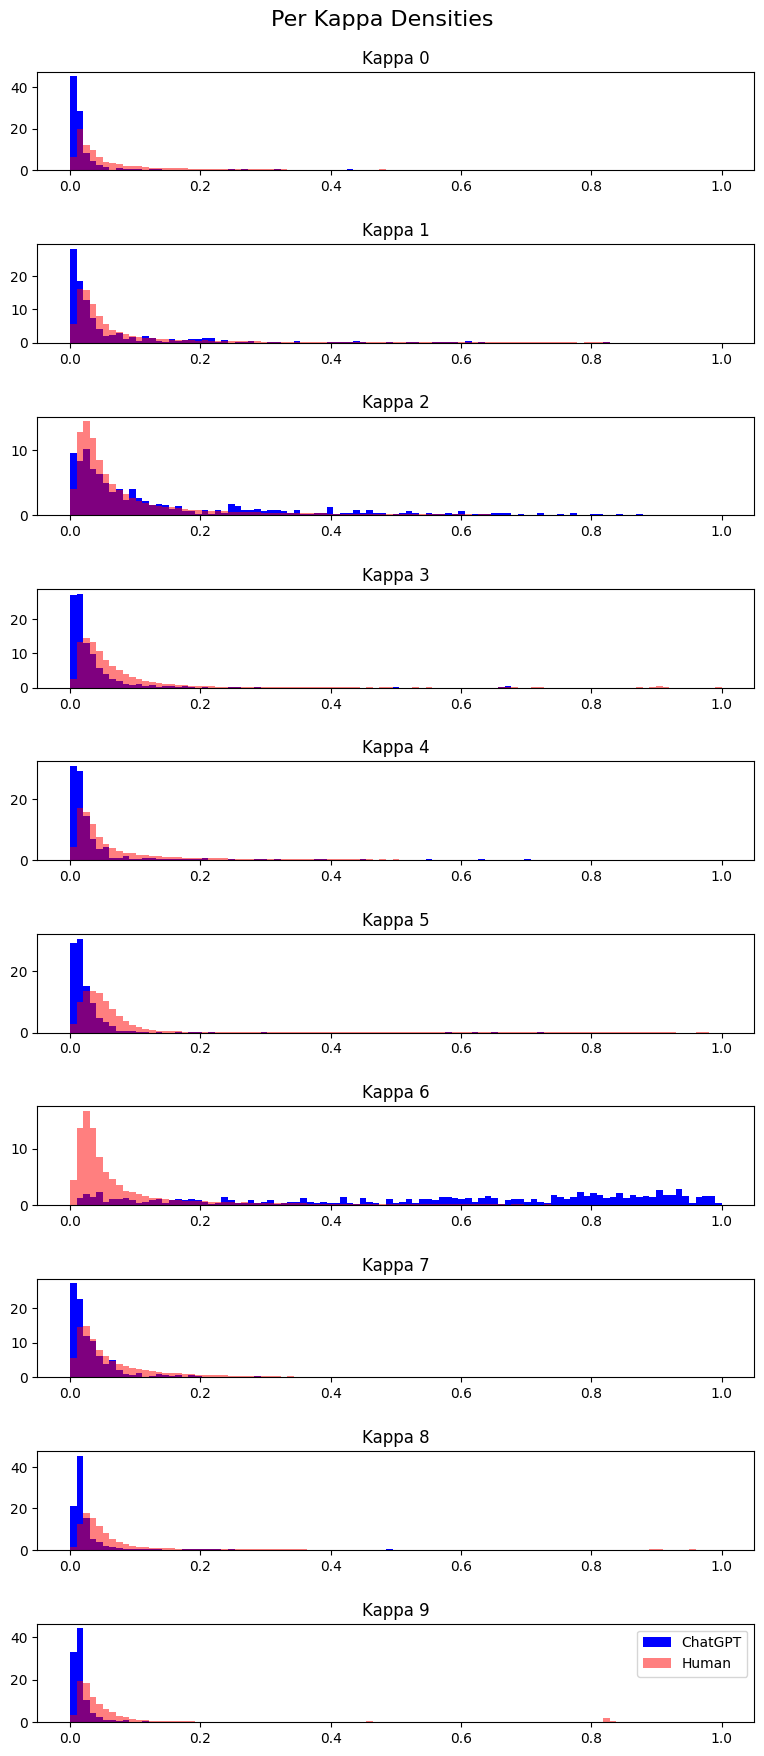

In [27]:

generate_per_feature_histogram(author_to_result, 'kappa')


torch.Size([1, 10])
0
1
2
3
4
5
6
7
8
9


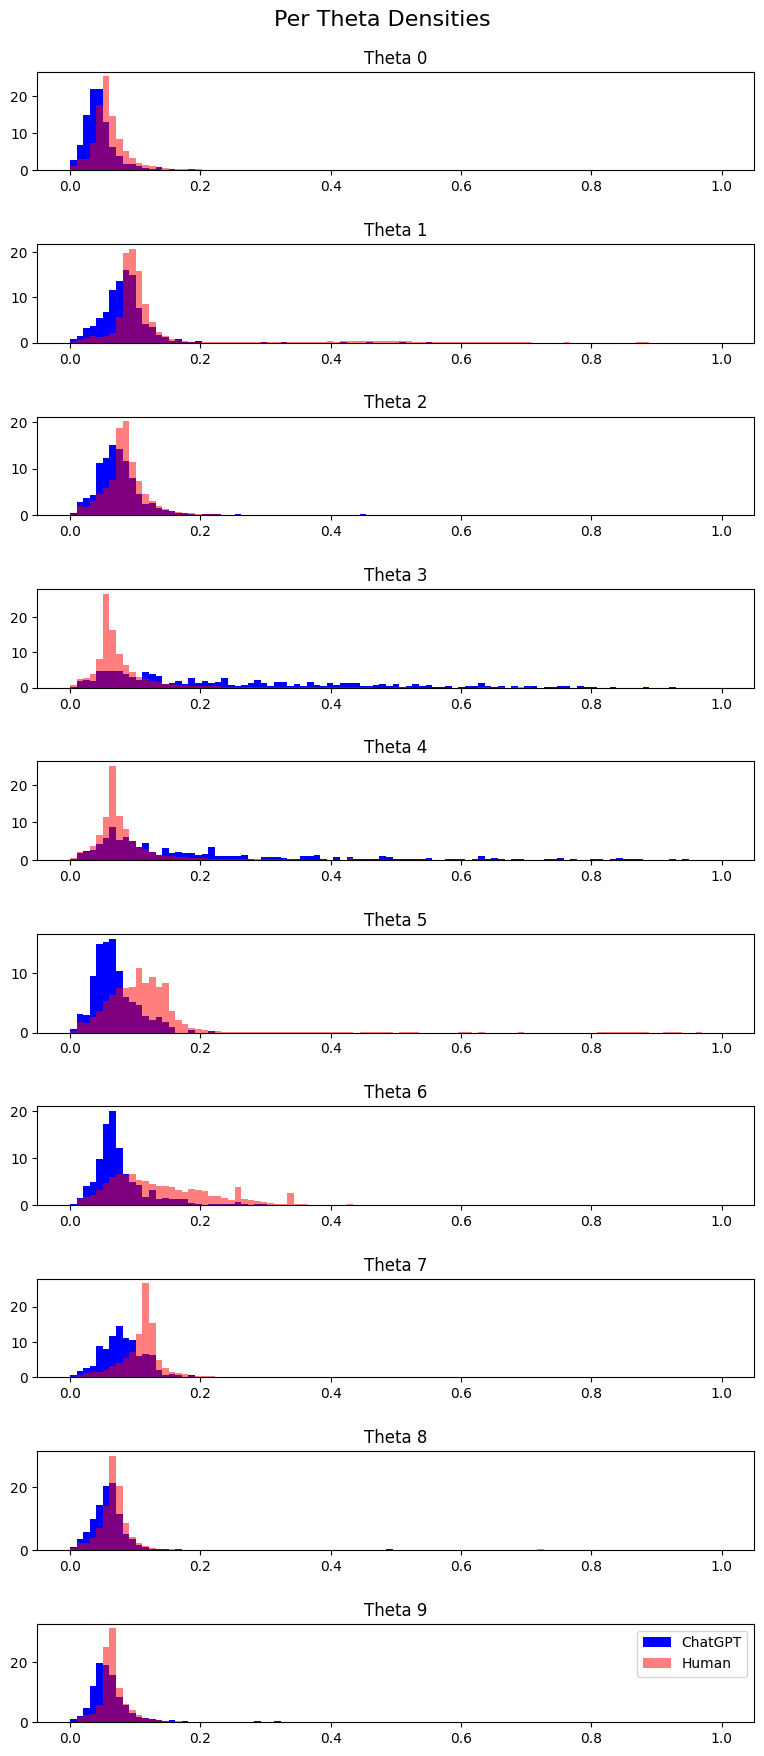

In [28]:
generate_per_feature_histogram(author_to_result, 'theta')

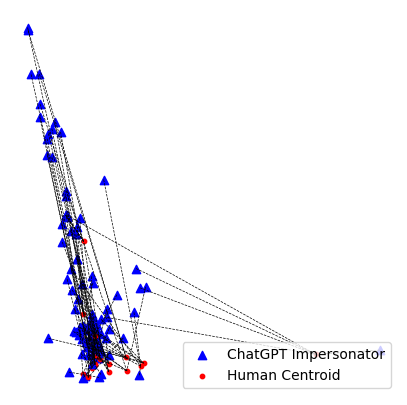

In [29]:
plot_projection_comparison(theta_proj[:,0], theta_proj[:,1], a_labels)

In [30]:
gpt_authors = {a:v for a,v in author_to_result.items() if a.startswith('gpt3.5_')}
human_authors = {a:v for a,v in author_to_result.items() if not a.startswith('gpt3.5_')}


In [31]:
# Load Anna Wegmann style embedding model

from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('AnnaWegmann/Style-Embedding')
embeddings = model.encode(sentences)
print(embeddings)


[[ 1.4103477e-01  2.0875008e-01  1.7136553e-01 ...  3.5445425e-01
   4.6482444e-01 -4.8658944e-06]
 [ 3.9674786e-01  1.5319376e-01  7.7176732e-03 ...  6.6641575e-01
   4.8512122e-01 -3.2561406e-01]]


In [32]:
# Generate input features for performing balanced ChatGPT vs Original Human classification

random.seed(42)
gpt_author_list = sorted(gpt_authors.keys())
random.shuffle(gpt_author_list)

num_styles = 10
train_split = 0.7

train_gpt_authors = set(gpt_author_list[:int(len(gpt_author_list)*train_split)])
test_gpt_authors = set(gpt_author_list[int(len(gpt_author_list)*train_split):])

input_features = {shard:{**{f'kappa_{i}':[] for i in range(num_styles)}, 'style_embed':[],  'theta_kappa':[], 'theta':[], 'kappa':[], 'text':[], 'labels':[], 'author':[]} for shard in ['training', 'test']}
for a in tqdm(gpt_authors):
    if a in train_gpt_authors:
        shard = 'training'
    else:
        shard = 'test'
    for text, theta, kappa in gpt_authors[a][:5]:
        input_features[shard]['theta'].append(theta[0])
        input_features[shard]['kappa'].append(kappa[0])
        for i in range(num_styles):
            input_features[shard][f'kappa_{i}'].append([kappa[0][i]])
        input_features[shard]['text'].append(text)
        input_features[shard]['labels'].append(1)
        input_features[shard]['style_embed'].append(model.encode([text])[0])


for a in tqdm(human_authors):
    if 'gpt3.5_'+a not in gpt_authors:
        continue
    if 'gpt3.5_'+a in train_gpt_authors:
        shard = 'training'
    else:
        shard = 'test'

    for text, theta, kappa in human_authors[a][:5]:
        input_features[shard]['theta'].append(theta[0])
        input_features[shard]['kappa'].append(kappa[0])
        for i in range(num_styles):
            input_features[shard][f'kappa_{i}'].append([kappa[0][i]])
        input_features[shard]['text'].append(text)
        input_features[shard]['labels'].append(0)
        input_features[shard]['style_embed'].append(model.encode([text])[0])

for shard in ['training', 'test']:
    input_features[shard]['theta'] = np.stack(input_features[shard]['theta'])
    input_features[shard]['kappa'] = np.stack(input_features[shard]['kappa'])
    input_features[shard]['labels'] = np.stack(input_features[shard]['labels'])
    input_features[shard]['theta_kappa'] = np.concatenate([input_features[shard]['theta'], input_features[shard]['kappa']], axis=-1)

    input_features[shard]['text'] = vectorizer.transform(input_features[shard]['text'])
    input_features[shard]['style_embed'] = np.stack(input_features[shard]['style_embed'])
    print(shard, input_features[shard]['theta'].shape)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 880/880 [00:06<00:00, 128.22it/s]

training (700, 10)
test (300, 10)


In [33]:
# Train classifier to identify ChatGPT vs Original Human

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score


for clf_type in ['logreg', 'knn', 'dt']:
    for type in ['theta', 'kappa',  'text', 'theta_kappa', 'style_embed'] + [f'kappa_{i}' for i in range(num_styles)]:
        train = input_features['training'][type]
        test = input_features['test'][type]
        train_labels = input_features['training']['labels']
        test_labels = input_features['test']['labels']

        if clf_type == 'logreg':
            clf = LogisticRegression(random_state=0).fit(train, train_labels)
        elif clf_type == 'knn':
            clf = KNeighborsClassifier(n_neighbors=3).fit(train, train_labels)
        elif clf_type == 'dt':
            clf = DecisionTreeClassifier(random_state=0).fit(train, train_labels)
        else:
            raise NotImplementedError()
        print(clf_type, type)
        preds = clf.predict(test)
        print(f1_score(test_labels, preds))
        print()

/home/horvitz/miniconda3/envs/style_lda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logreg theta
0.7970479704797049

logreg kappa
0.8737201365187713

logreg text
0.9215017064846417

logreg theta_kappa
0.8758620689655173

logreg style_embed
0.913907284768212

logreg kappa_0
0.7371134020618556

logreg kappa_1
0.6478873239436621

logreg kappa_2
0.39183673469387753

logreg kappa_3
0.7103825136612022

logreg kappa_4
0.6984924623115577

logreg kappa_5
0.7573333333333333

logreg kappa_6
0.8450704225352113

logreg kappa_7
0.6950000000000001

logreg kappa_8
0.7597765363128492

logreg kappa_9
0.7596899224806202

knn theta
0.7816901408450704

knn kappa
0.8448844884488449

knn text
0.6603325415676959

knn theta_kappa


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


0.8504983388704319

knn style_embed
0.8063492063492064

knn kappa_0
0.7171052631578947

knn kappa_1
0.6209150326797385

knn kappa_2
0.5

knn kappa_3
0.6870748299319728

knn kappa_4
0.6468646864686468

knn kappa_5
0.7448275862068965

knn kappa_6
0.8160535117056856

knn kappa_7
0.7046979865771812

knn kappa_8
0.7804878048780487

knn kappa_9
0.7375415282392026

dt theta
0.7253521126760563

dt kappa
0.8092105263157896

dt text
0.8617363344051446

dt theta_kappa
0.8486842105263157

dt style_embed
0.78

dt kappa_0
0.6644951140065146

dt kappa_1
0.6233766233766234

dt kappa_2
0.5405405405405406

dt kappa_3
0.6513157894736842

dt kappa_4
0.6384364820846906

dt kappa_5
0.711864406779661

dt kappa_6
0.7662337662337663

dt kappa_7
0.6516129032258063

dt kappa_8
0.7872340425531915

dt kappa_9
0.7572815533980584



In [34]:
# Generatr authorship pairs for verification task

def generate_verification_pairs(author_list, author_dict, max_per_author=10):
    author_to_num = {}
    for a in author_list:
        author_to_num[a] = len(author_dict[a])

    for a in author_list:
        assert a in author_to_num
    
    verification_pairs = []
    for a in tqdm(author_list):
        options = list(range(author_to_num[a]))
        chosen = random.sample(options, min(max_per_author, len(options)))
        for c in chosen:
            same_author_options = list(range(author_to_num[a]))
            same_author_options.remove(c)
            if len(same_author_options) == 0:
                continue
            same_author_idx = random.choice(same_author_options)
            verification_pairs.append((a, c, a, same_author_idx)) 

            other_author = random.choice([a2 for a2 in author_list if a2 != a])
            other_author_options = list(range(author_to_num[other_author]))
            other_author_idx = random.choice(other_author_options)

            verification_pairs.append((a, c, other_author, other_author_idx))



    return verification_pairs
            

           


In [35]:
# Generate data for verification task



random.seed(42)
human_authors = {a:v for a,v in author_to_result.items() if not a.startswith('gpt3.5_')}
human_author_list = sorted(human_authors.keys())
random.shuffle(human_author_list)

train_split = 0.8

train_human_authors = sorted(set(human_author_list[:int(len(human_author_list)*train_split)]))
test_human_authors = sorted(set(human_author_list[int(len(human_author_list)*train_split):]))


pairs = {
    'training': generate_verification_pairs(train_human_authors, human_authors, max_per_author=5),
    'test': generate_verification_pairs(test_human_authors, human_authors, max_per_author=5)
}

input_features = {shard:{'style_embed':[], 'theta_kappa':[], 'theta':[], 'kappa':[], 'text':[], 'labels':[], 'author':[]} for shard in ['training', 'test']}

for shard in ['training', 'test']:
    for a1, i1, a2, i2 in tqdm(pairs[shard]):
        text1, theta1, kappa1 = human_authors[a1][i1]
        text2, theta2, kappa2 = human_authors[a2][i2]

        theta1 = theta1[0]
        kappa1 = kappa1[0]
        theta2 = theta2[0]
        kappa2 = kappa2[0]

        combined_theta = np.concatenate([theta1, theta2])
        combined_kappa = np.concatenate([kappa1, kappa2])
        text1_vec = vectorizer.transform([text1]).toarray()[0]
        text2_vec = vectorizer.transform([text2]).toarray()[0]
        combined_text = np.concatenate([text1_vec, text2_vec])
        combined_style_embed = np.concatenate([model.encode([text1])[0], model.encode([text2])[0]])
        label = 1 if a1 == a2 else 0

        input_features[shard]['theta'].append(combined_theta)
        input_features[shard]['kappa'].append(combined_kappa)
        input_features[shard]['text'].append(combined_text)
        input_features[shard]['theta_kappa'].append(np.concatenate([combined_theta, combined_kappa], axis=-1))
        input_features[shard]['labels'].append(label)
        input_features[shard]['style_embed'].append(combined_style_embed)


    

            



  0%|          | 0/704 [00:00<?, ?it/s]

100%|██████████| 1760/1760 [00:48<00:00, 36.32it/s]


In [36]:
# Perform verification task

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPClassifier


# split_inputs = False

for clf_type in ['mlp']:
    for type in ['theta', 'kappa', 'theta_kappa', 'text', 'style_embed']:
        train = np.stack(input_features['training'][type])
        test = np.stack(input_features['test'][type])

        # if split_inputs:
        #     print(train.shape)
        #     print(test.shape)
        #     train1 = train[:, :train.shape[1]//2]
        #     train2 = train[:, train.shape[1]//2:]
        #     test1 = test[:, :test.shape[1]//2]
        #     test2 = test[:, test.shape[1]//2:]

        #     train = np.array([cosine_similarity([x1], [x2])[0] for x1, x2 in zip(train1, train2)])
        #     test = np.array([cosine_similarity([x1], [x2])[0]  for x1, x2 in zip(test1, test2)])

        #     print(train.shape)
        #     print(test.shape)

        train_labels = input_features['training']['labels']
        test_labels = input_features['test']['labels']

        if clf_type == 'logreg':
            continue
            clf = LogisticRegression(random_state=0).fit(train, train_labels)
        elif clf_type == 'knn':
            continue
            clf = KNeighborsClassifier(n_neighbors=3).fit(train, train_labels)
        elif clf_type == 'dt':
            continue
            clf = DecisionTreeClassifier(random_state=0).fit(train, train_labels)
        elif clf_type == 'mlp':
            clf = MLPClassifier(random_state=1, max_iter=1000).fit(train, train_labels)
        else:
            raise NotImplementedError()
        print(clf_type, type)
        print(clf.score(test, test_labels))

        # preds = clf.predict(test)
        # print(f1_score(test_labels, preds))
        # print(precision_score(test_labels, preds))
        # print(recall_score(test_labels, preds))
        # print()

mlp theta
0.5829545454545455
mlp kappa
0.5823863636363636
mlp theta_kappa
0.5659090909090909
mlp text
0.5210227272727272
mlp style_embed
0.5625
